In [2]:
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import isinf
import librosa
import librosa.display as disp
import os
from numpy import array, zeros, full, argmin, inf, ndim
import math

# Load Audio Recordings

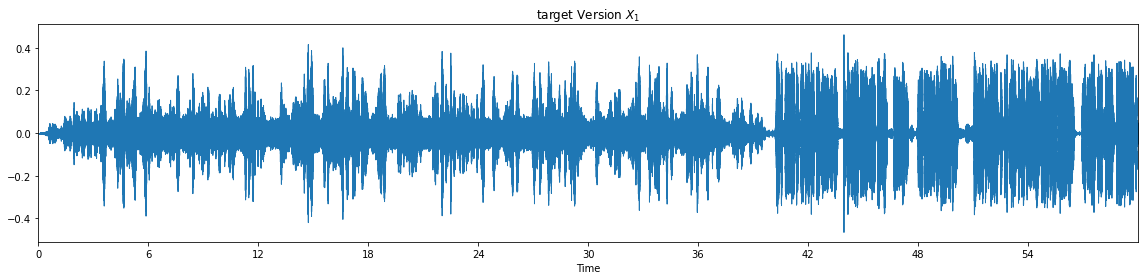

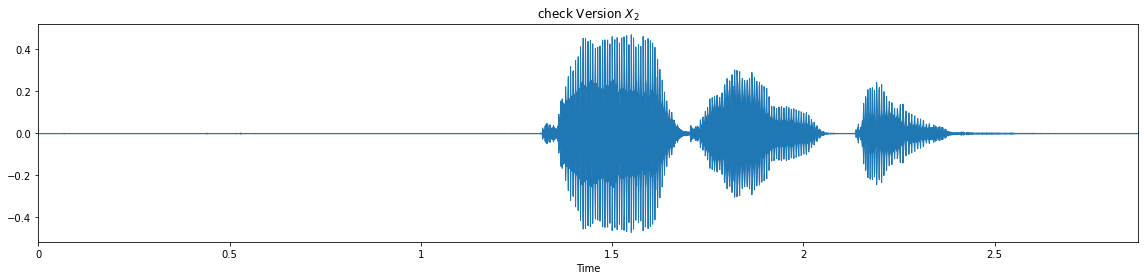

In [3]:
audio=os.path.join(os.getcwd(),"audio_file")
x_1, sr = librosa.load(os.path.join(audio,"j&tmaaf.ogg"),duration=60)
plt.figure(figsize=(16, 4))
disp.waveplot(x_1, sr)
plt.title('target Version $X_1$')
plt.tight_layout()

x_2, fs = librosa.load(os.path.join(audio,"j&t.ogg"),duration=60)
plt.figure(figsize=(16, 4))
disp.waveplot(x_2, sr=fs)
plt.title('check Version $X_2$')
plt.tight_layout()

# Extract Chroma Features

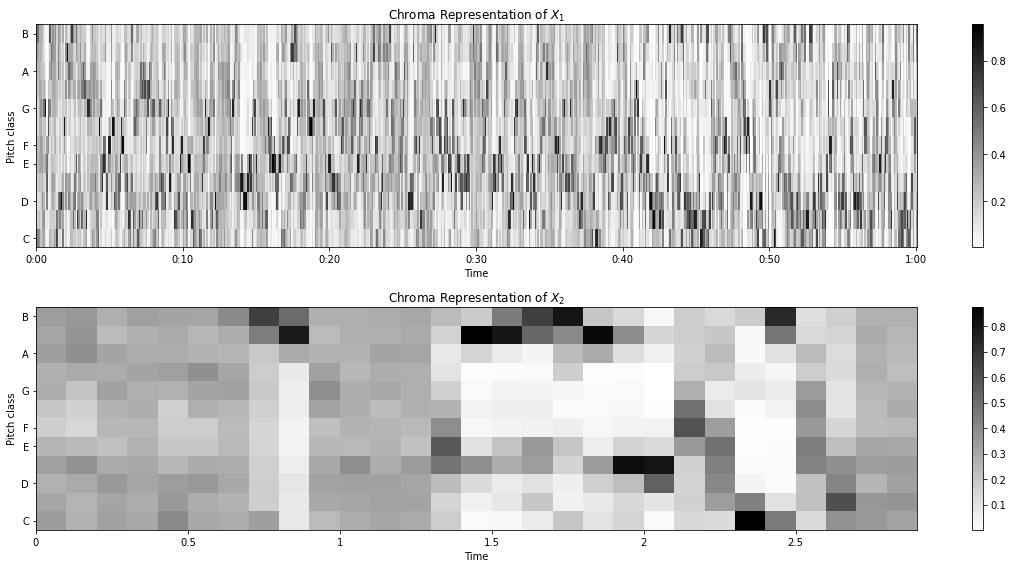

In [4]:
n_fft = 4410
hop_size = 2205

x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X_1$')
librosa.display.specshow(x_1_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X_2$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

In [26]:
def dtw(array1, array2):
    len1 = len(array1)
    len2 = len(array2)
    dtw_matrix = np.zeros((len1+1,len2+1))
    
    for i in range(len1+1):
        for j in range(len2+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0,0] = 0
    
    for i in range(1, len1+1):
        for j in range(1, len2+1):
            cost = abs(array1[i-1] - array2[j-1])
            
            last_min = np.min([dtw_matrix[i-1,j], dtw_matrix[i,j-1],dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
            print(dtw_matrix[i,j])
    return dtw_matrix

def dtw2(x, y, dist, warp=1, w=inf, s=1.0):
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                # print(D1)
                # print(math.dist(x[i], y[j]))
                D1[i, j] = math.dist(x[i], y[j])
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

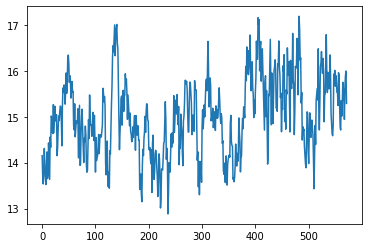

In [27]:
frame=x_2_chroma.shape[1]
dist=np.zeros(x_1_chroma.shape[1]-frame)
# print(x_1_chroma[:,0:])
# print(len(x_2_chroma))
# print(x_2_chroma)
# print(len(x_1_chroma[1])-len(x_2_chroma[1]))
for i in range (len(dist)):
   sliced=x_1_chroma[:,i:i+frame]
   dist[i]=dtw2(sliced,x_2_chroma,dist=lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    # print(dtw(x_1_chromaframe,x_2_chroma))
plt.plot(dist)


In [20]:
# print(x_1_chroma[1])
manhattan_distance = np.abs(x_1_chroma - x_2_chroma)
d, cost_matrix, acc_cost_matrix, path =dtw2(x_1_chroma,x_2_chroma,dist=manhattan_distance)
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

ValueError: operands could not be broadcast together with shapes (12,601) (12,29) 

# Align Chroma Sequences

In [ ]:
D, wp = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()

# Alternative Visualization in the Time Domain

In [ ]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs)
plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs)
plt.title('Slower Version $X_2$')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()